In [30]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


### Lagekennzahlen (Analyse der Prevalence Rate)

In [31]:
# Beispiel: Prevalence Rate (%)
s = ds["amt"].dropna()

print("Mittelwert:", s.mean())
print("Median:", s.median())
print("Quantile (25%,50%,75%):", s.quantile([0.25,0.5,0.75]).to_dict())
print("Modus:", s.mode().tolist())
print("min, max:", s.min(), s.max())

q_low, q_high = s.quantile(0.1), s.quantile(0.9)
trimmed = s[(s >= q_low) & (s <= q_high)].mean()
print("Trimmed Mean (10%):", trimmed)

Mittelwert: 70.35103545607033
Median: 47.52
Quantile (25%,50%,75%): {0.25: 9.65, 0.5: 47.52, 0.75: 83.14}
Modus: [1.14]
min, max: 1.0 28948.9
Trimmed Mean (10%): 49.832946291234734


### Streuung

In [32]:
print("Varianz:", s.var())
print("Standardabweichung:", s.std())
iqr = s.quantile(0.75) - s.quantile(0.25)
mad = (s - s.median()).abs().median()
print("IQR:", iqr)
print("MAD:", mad)

Varianz: 25701.232223267572
Standardabweichung: 160.31603857152774
IQR: 73.49
MAD: 37.5


### Ausreisserprüfung

##### Klassisch: Z-Score

In [33]:
z = (s - s.mean()) / s.std()
outliers_z = s[abs(z) > 3]
z_lower = s.mean() - 3 * s.std()
z_upper = s.mean() + 3 * s.std()
print("Anzahl Ausreißer (Z-Score >3):", len(outliers_z))

Anzahl Ausreißer (Z-Score >3): 12738


##### Tukey

In [34]:
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_tukey = s[(s < lower_bound) | (s > upper_bound)]

print("Anzahl Ausreißer (Tukey 1.5×IQR):", len(outliers_tukey))
print("Tukey-Grenzen:")
print("Untere Grenze:", lower_bound)
print("Obere Grenze:", upper_bound)

Anzahl Ausreißer (Tukey 1.5×IQR): 67290
Tukey-Grenzen:
Untere Grenze: -100.58499999999998
Obere Grenze: 193.375


##### Modifizierter Z-Score

In [35]:
median = s.median()
mad = (s - median).abs().median()
mod_z = 0.6745 * (s - median) / mad
outliers_modz = s[mod_z.abs() > 3.5]

k = (3.5 / 0.6745) * mad
modz_lower = median - k
modz_upper = median + k

print("Anzahl Ausreißer (mod. Z-Score >3.5):", len(outliers_modz))

Anzahl Ausreißer (mod. Z-Score >3.5): 40359


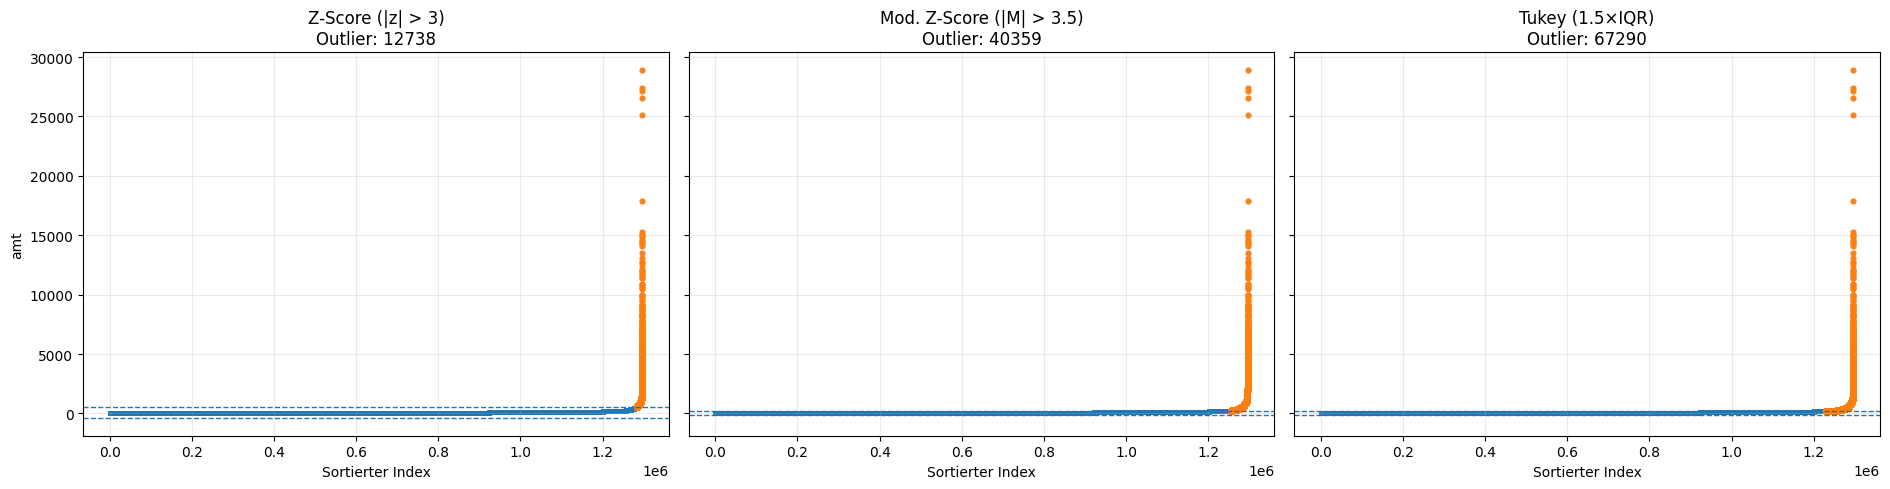

In [36]:
# Alle Punkte sortiert darstellen
s_sorted = s.sort_values()
idx = np.arange(len(s_sorted))

# Masken: welche Indizes sind Outlier?
mask_z = s_sorted.index.isin(outliers_z.index)
mask_tukey = s_sorted.index.isin(outliers_tukey.index)
mask_modz = s_sorted.index.isin(outliers_modz.index)

fig, axes = plt.subplots(1, 3, figsize=(19, 5), sharey=True)

def plot_outliers(ax, title, mask, lower, upper):
    ax.scatter(idx, s_sorted.values, s=6, alpha=0.35)
    # Ausreißer markieren (drunter oder drüber)
    ax.scatter(idx[mask], s_sorted.values[mask], s=12, alpha=0.9)

    # Grenzen einzeichnen
    ax.axhline(lower, linestyle="--", linewidth=1)
    ax.axhline(upper, linestyle="--", linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("Sortierter Index")
    ax.grid(alpha=0.25)

axes[0].set_ylabel("amt")

plot_outliers(
    axes[0],
    f"Z-Score (|z| > 3)\nOutlier: {len(outliers_z)}",
    mask_z,
    z_lower,
    z_upper
)

plot_outliers(
    axes[2],
    f"Tukey (1.5×IQR)\nOutlier: {len(outliers_tukey)}",
    mask_tukey,
    lower_bound,
    upper_bound
)

plot_outliers(
    axes[1],
    f"Mod. Z-Score (|M| > 3.5)\nOutlier: {len(outliers_modz)}",
    mask_modz,
    modz_lower,
    modz_upper
)

plt.tight_layout()
plt.show()

## Erkenntnis aus der Ausreißerprüfung

Die Analyse der Transaktionsbeträge (*amt*) zeigt eine stark rechtsschiefe
Verteilung mit einer ausgeprägten Heavy-Tail-Struktur. Hohe Beträge treten
selten, aber regelmäßig auf und dominieren die rechte Seite der Verteilung.

Der klassische Z-Score (|z| > 3) identifiziert 12 738 Beobachtungen als
Ausreißer. Der modifizierte Z-Score (|M| > 3.5), der robuster gegenüber
Schiefe ist, klassifiziert mit 40 359 Beobachtungen einen deutlich größeren
Anteil als Ausreißer. Die Tukey-Methode (1.5 × IQR) ist am sensitivsten und
identifiziert 67 290 Ausreißer, ausschließlich im oberen Bereich der
Verteilung.

Die Unterschiede zwischen den Methoden zeigen, dass die identifizierten
Ausreißer keine offensichtlichen Datenfehler sind. Es handelt sich vielmehr
um sehr hohe, aber realistische Transaktionsbeträge. Solche Extremwerte sind
typisch für reale Kreditkartendaten und können für die spätere Analyse der
Betrugsfälle wichtige Informationen enthalten.

Zur besseren Visualisierung und Analyse der stark schiefen Verteilung werden
in den folgenden Notebooks logarithmische Darstellungen verwendet. Die
Transaktionsbeträge werden jedoch unverändert im Datensatz belassen, um die
vollständige Informationsbasis zu erhalten.

### Verteilungsform (in VL3(Analyse_3.ipynb) genauer)

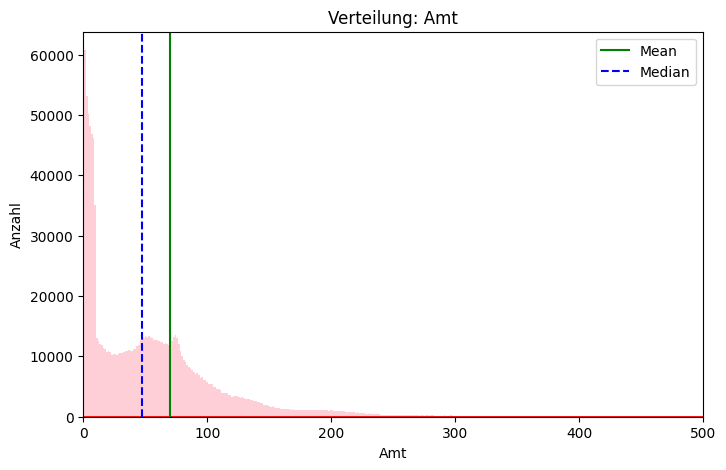

In [37]:
plt.figure(figsize=(8,5))

# Histogramm mit normalen Häufigkeiten (Counts)
sns.histplot(s, bins="fd", color="pink", edgecolor="purple", stat="count")

# KDE separat in anderer Farbe
sns.kdeplot(s, color="red", lw=2)

# Mittelwert und Median einzeichnen
plt.axvline(s.mean(), color="green", linestyle="-", label="Mean")
plt.axvline(s.median(), color="blue", linestyle="--", label="Median")

plt.title("Verteilung: Amt")
plt.xlabel("Amt")
plt.ylabel("Anzahl")
plt.xlim(0, 500) # Begrenzung des x-Achsenbereichs
plt.legend()
plt.show()

In [38]:


ds["dob"] = pd.to_datetime(ds["dob"], errors="coerce")  # sicherstellen, dass es Datumswerte sind
ds["age"] = (pd.Timestamp("now") - ds["dob"]).dt.days / 365.25  # Alter in Jahren

suitable_cols = ["city_pop", "age"]

for col in suitable_cols:
    print("\n---", col, "---")
    s = ds[col].dropna()
    print("Mean:", round(s.mean(), 2))
    print("Median:", round(s.median(), 2))
    print("Std:", round(s.std(), 2))



--- city_pop ---
Mean: 88824.44
Median: 2456.0
Std: 301956.36

--- age ---
Mean: 52.21
Median: 50.05
Std: 17.39


In [39]:
print(ds.groupby("gender")["age"].agg(["mean", "median", "std", "count"]).round(2))


          mean  median     std   count
gender                                
F      52.1100 49.9600 17.4900  709863
M      52.3300 50.4500 17.2700  586812
